In [16]:
import pandas as pd
import urllib.request
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

url = "https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/parcours-data-scientist/P2/fr.openfoodfacts.org.products.csv.zip"
urllib.request.urlretrieve(url, "./fr.openfoodfacts.org.products.csv.zip")

('./fr.openfoodfacts.org.products.csv.zip',
 <http.client.HTTPMessage at 0x28efdfd03b0>)

In [17]:
with zipfile.ZipFile("./fr.openfoodfacts.org.products.csv.zip", 'r') as zip_ref:
    with zip_ref.open('fr.openfoodfacts.org.products.csv') as file:
        data = pd.read_csv(file, sep="\t", low_memory=False)

In [18]:
varList = data.columns.tolist()
sizeData = data.shape[0]
print(varList)

['code', 'url', 'creator', 'created_t', 'created_datetime', 'last_modified_t', 'last_modified_datetime', 'product_name', 'generic_name', 'quantity', 'packaging', 'packaging_tags', 'brands', 'brands_tags', 'categories', 'categories_tags', 'categories_fr', 'origins', 'origins_tags', 'manufacturing_places', 'manufacturing_places_tags', 'labels', 'labels_tags', 'labels_fr', 'emb_codes', 'emb_codes_tags', 'first_packaging_code_geo', 'cities', 'cities_tags', 'purchase_places', 'stores', 'countries', 'countries_tags', 'countries_fr', 'ingredients_text', 'allergens', 'allergens_fr', 'traces', 'traces_tags', 'traces_fr', 'serving_size', 'no_nutriments', 'additives_n', 'additives', 'additives_tags', 'additives_fr', 'ingredients_from_palm_oil_n', 'ingredients_from_palm_oil', 'ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil', 'ingredients_that_may_be_from_palm_oil_tags', 'nutrition_grade_uk', 'nutrition_grade_fr', 'pnns_groups_1', 

In [19]:
startNut = varList.index("energy_100g")
print(startNut)

63


In [20]:
size = data[data.duplicated()].shape[0]
if size == 0:
    print("No exact duplicated")
else:
    print(f"exact duplicated :{size}")
subset = ['code']
size = size_subset = data.dropna(subset=subset).duplicated(subset=subset).sum()
if size == 0:
    print(f"No possible duplicated with subset : {subset}")
else:
    print(f"exact duplicated with subset {subset} :{size}")
subset = ['product_name', 'creator', 'quantity']
size = size_subset = data.dropna(subset=subset).duplicated(subset=subset).sum()
if size == 0:
    print(f"No possible duplicated with subset : {subset}")
else:
    print(f"Possible duplicated with subset {subset} :{size}")
subset = ['product_name', 'brands', 'quantity', 'categories', 'countries']
size = size_subset = data.dropna(subset=subset).duplicated(subset=subset).sum()
if size == 0:
    print(f"No possible duplicated with subset : {subset}")
else:
    print(f"Possible duplicated with subset {subset} :{size}")


No exact duplicated
No possible duplicated with subset : ['code']
Possible duplicated with subset ['product_name', 'creator', 'quantity'] :1939
Possible duplicated with subset ['product_name', 'brands', 'quantity', 'categories', 'countries'] :138


In [21]:
missingRate = data.iloc[:, :startNut].isnull().sum()/sizeData
print(missingRate.shape[0])
print(missingRate[missingRate >= 0.5])

63
generic_name                                 0.84
quantity                                     0.67
packaging                                    0.75
packaging_tags                               0.75
categories                                   0.74
categories_tags                              0.74
categories_fr                                0.74
origins                                      0.93
origins_tags                                 0.93
manufacturing_places                         0.89
manufacturing_places_tags                    0.89
labels                                       0.85
labels_tags                                  0.85
labels_fr                                    0.85
emb_codes                                    0.91
emb_codes_tags                               0.91
first_packaging_code_geo                     0.94
cities                                       1.00
cities_tags                                  0.94
purchase_places                              0.

In [22]:
missingRateNut = data.iloc[:, startNut:].isnull().sum()/sizeData
print(missingRateNut.shape[0])
print(missingRateNut[missingRateNut >= 0.5])

99
energy-from-fat_100g    1.00
butyric-acid_100g       1.00
caproic-acid_100g       1.00
caprylic-acid_100g      1.00
capric-acid_100g        1.00
                        ... 
cocoa_100g              1.00
chlorophyl_100g         1.00
carbon-footprint_100g   1.00
glycemic-index_100g     1.00
water-hardness_100g     1.00
Length: 88, dtype: float64


In [23]:
def prepareData(data, targetColumn, subsetDup):
    if targetColumn not in data.columns:
        raise ValueError(f"{targetColumn} is not in dataFrame.")

    dataCleaned = data.dropna(subset=[targetColumn])
    y = dataCleaned[targetColumn]
    X = dataCleaned.drop(columns=[targetColumn])

    columnsKeep = X.columns[X.isnull().mean() < 0.5]
    X = X[columnsKeep]
    
    subsetDup = [col for col in subsetDup if col in X.columns]
    
    if subsetDup:
        X = X.drop_duplicates(subset=subsetDup)
        y = y.loc[X.index]
    else:
        print("No target for subsetDup.")
    return X, y

In [24]:
try:
    subsetDup = ['product_name', 'brands', 'quantity', 'categories', 'countries']
    XClean, y = prepareData(data, 'nutrition_grade_fr', subsetDup)

    print("Nb raws after clean :", len(XClean))
    print("Nb features:", XClean.shape[1])
    columnsX = XClean.columns.tolist()
    print("\n10 first features:")
    print(columnsX[:10])
    startNut = columnsX.index("energy_100g")
    print("\nFeatures nutritional:")
    print(columnsX[startNut : ])
    print("\nDistribution of the target variable:")
    print(y.value_counts(normalize=True))
    
    print("\nDescriptive statistics for some numeric columns:")
    numericColumns = [
    'energy_100g',
    'fat_100g',
    'saturated-fat_100g',
    'sugars_100g',
    'fiber_100g',
    'proteins_100g',
    'salt_100g',
    'sodium_100g'
    ]
    print(f'Features needed in Nutriscoring : {numericColumns}')
    numericColumns = [col for col in numericColumns if col in XClean.columns]
    pd.set_option('display.float_format', '{:.2f}'.format)
    print(XClean[numericColumns].describe())

except Exception as e:
    print(f"Error : {e}")

Nb raws after clean : 205268
Nb features: 41

10 first features:
['code', 'url', 'creator', 'created_t', 'created_datetime', 'last_modified_t', 'last_modified_datetime', 'product_name', 'brands', 'brands_tags']

Features nutritional:
['energy_100g', 'fat_100g', 'saturated-fat_100g', 'trans-fat_100g', 'cholesterol_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'vitamin-a_100g', 'vitamin-c_100g', 'calcium_100g', 'iron_100g', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g']

Distribution of the target variable:
nutrition_grade_fr
d   0.28
c   0.21
e   0.19
a   0.16
b   0.15
Name: proportion, dtype: float64

Descriptive statistics for some numeric columns:
Features needed in Nutriscoring : ['energy_100g', 'fat_100g', 'saturated-fat_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g']
       energy_100g  fat_100g  saturated-fat_100g  sugars_100g  fiber_100g  \
count    205083.00 188183.00           2050

In [25]:
def clean_outliers(df, columns, lower_percentile=0.01, upper_percentile=0.9999):
    df_cleaned = df.copy()
    for col in columns:
        if np.issubdtype(df_cleaned[col].dtype, np.number):
            lower = df_cleaned[col].quantile(lower_percentile)
            upper = df_cleaned[col].quantile(upper_percentile)
            df_cleaned[col] = df_cleaned[col].clip(lower, upper)
        else:
            print(f"Column {col} not a number.")
    return df_cleaned

In [26]:
XClean = clean_outliers(XClean, numericColumns)

In [27]:
def plot_boxplots(df, columns):
    plt.figure(figsize=(15, 5 * (len(columns) // 3 + 1)))
    for i, col in enumerate(columns, 1):
        plt.subplot(len(columns) // 3 + 1, 3, i)
        sns.boxplot(x=df[col])
    plt.tight_layout()
    plt.show()

In [28]:
def plot_histograms(df, columns):
    plt.figure(figsize=(15, 5 * (len(columns) // 3 + 1)))
    for i, col in enumerate(columns, 1):
        plt.subplot(len(columns) // 3 + 1, 3, i)
        sns.histplot(df[col], kde=True)
        plt.title(f'Distribution of {col}')
        print(f"Mean of {col} : {df[col].mean()}")
    plt.tight_layout()
    plt.show()

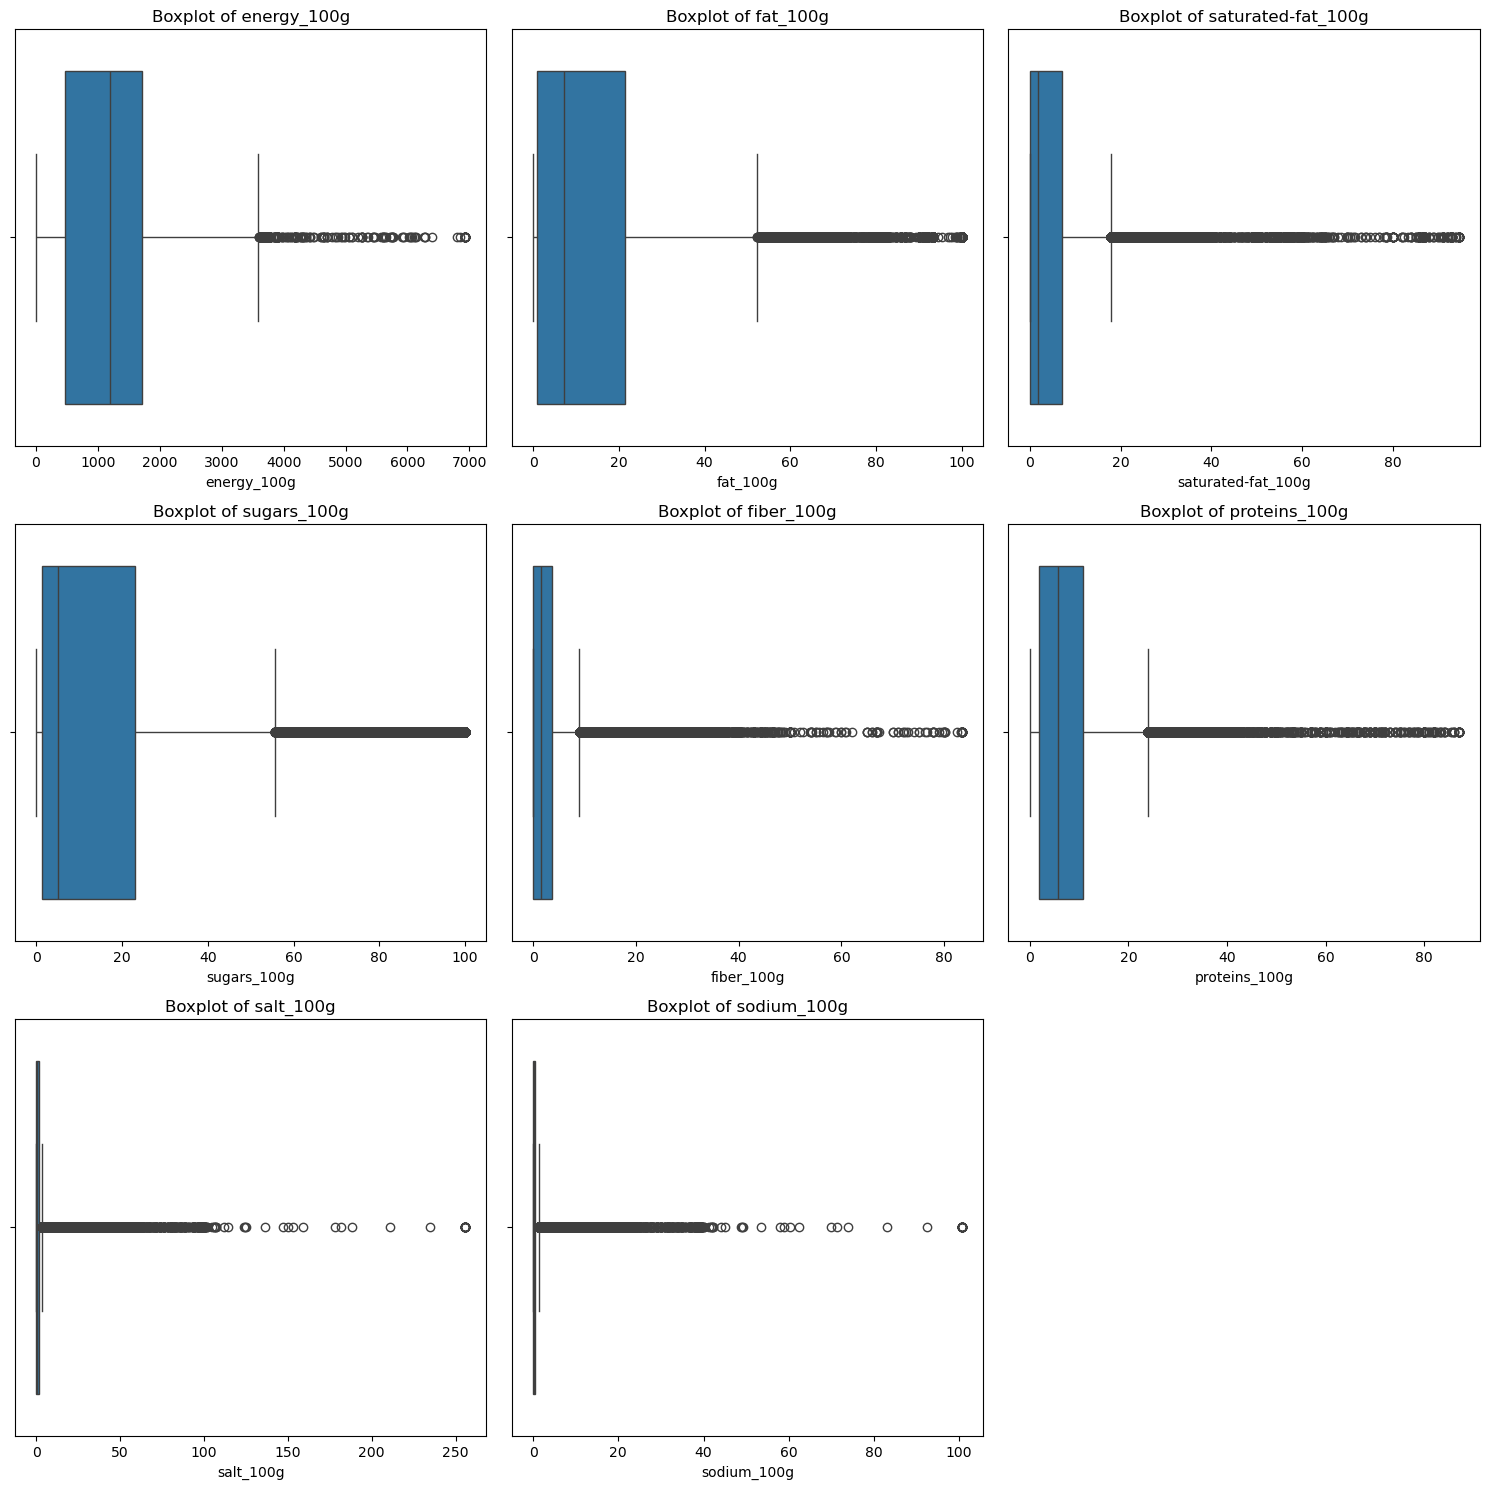

In [29]:
plot_boxplots(XClean, numericColumns)

Mean of energy_100g : 1179.8869665959637
Mean of fat_100g : 13.334569562606609
Mean of saturated-fat_100g : 4.975652602263473
Mean of sugars_100g : 14.963757348390649
Mean of fiber_100g : 2.809124990804416
Mean of proteins_100g : 7.772098307026908
Mean of salt_100g : 1.290513983288151
Mean of sodium_100g : 0.5080762418925446


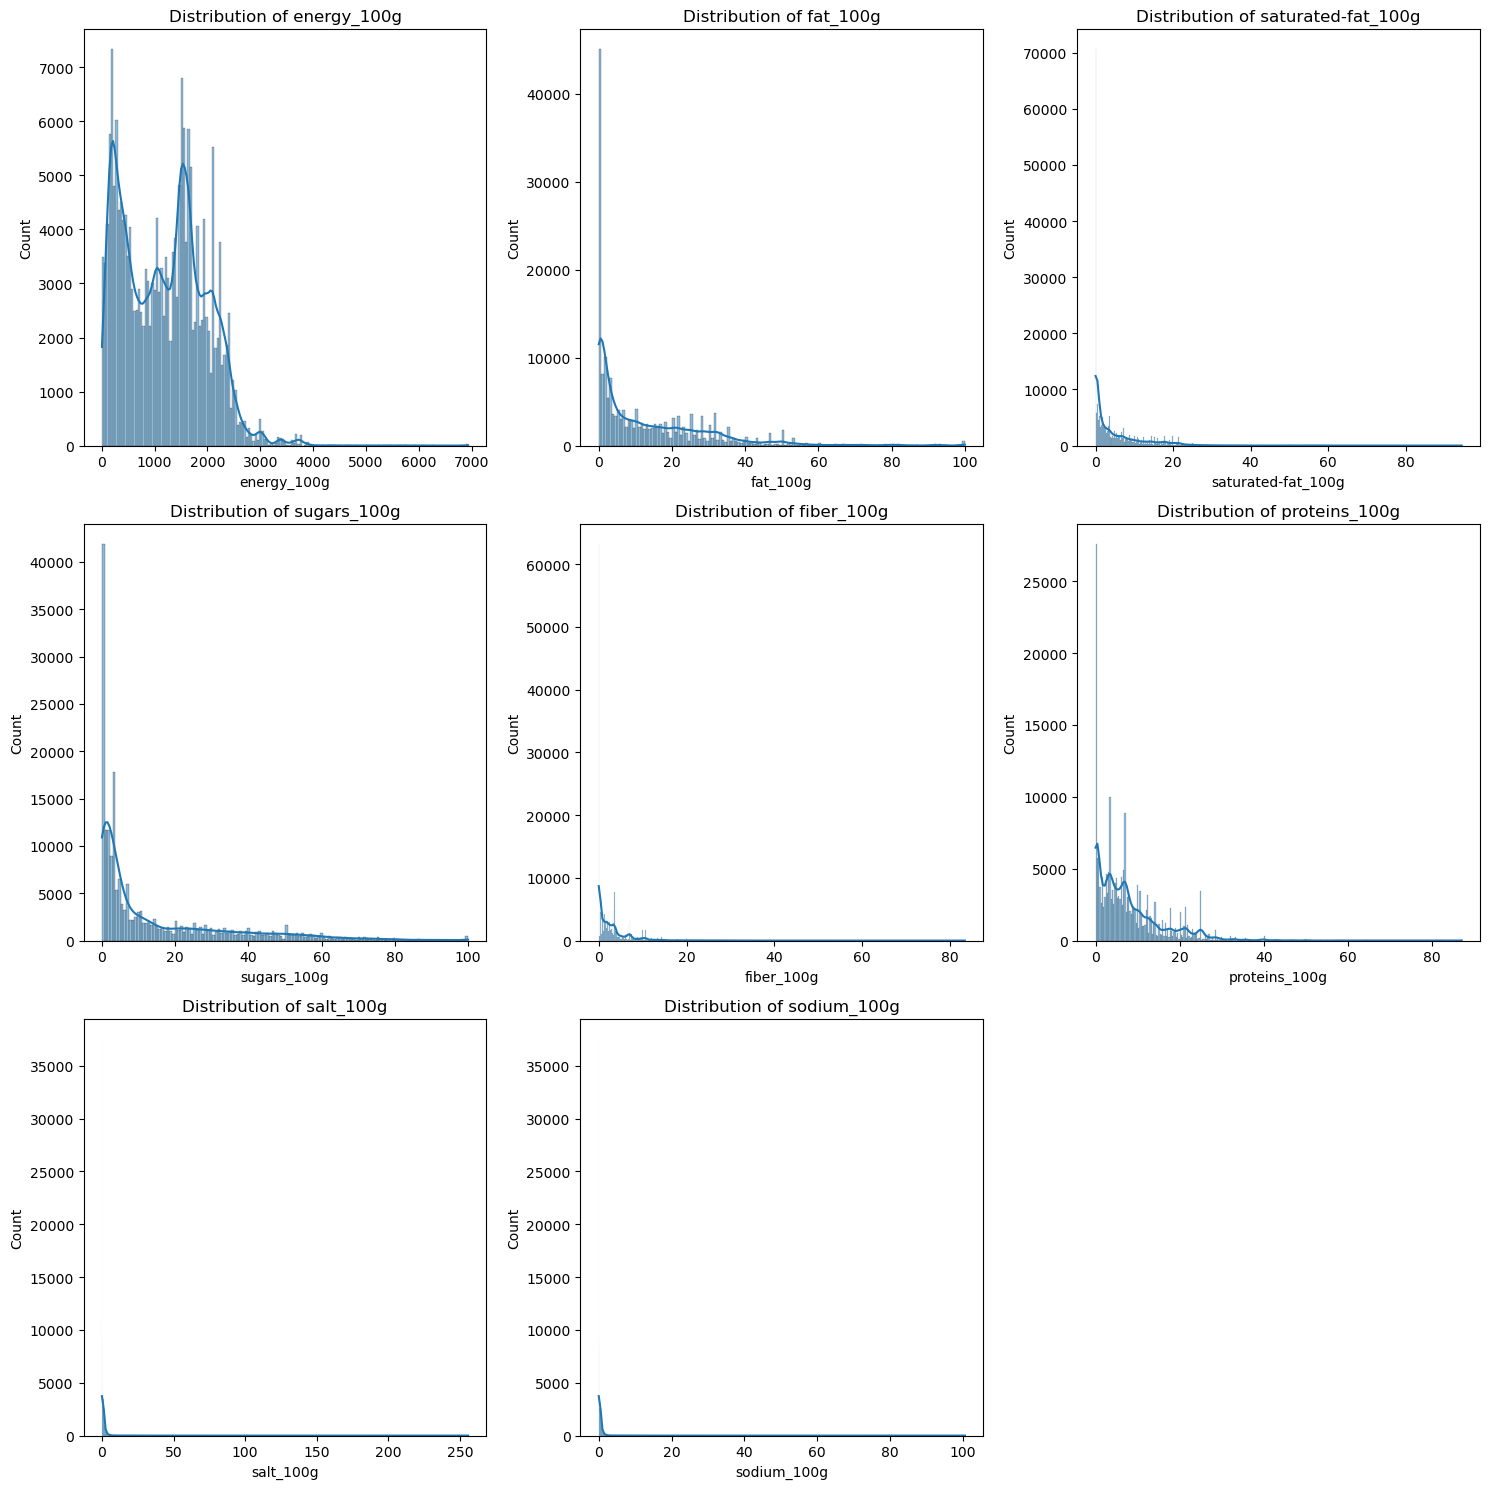

In [30]:
plot_histograms(XClean, numericColumns)

In [31]:
def treat_outliers(df, thresholds):
    df_cleaned = df.copy()
    for col, (min_val, max_val) in thresholds.items():
        if col in df.columns:
            df_cleaned.loc[df_cleaned[col] < min_val, col] = min_val
            df_cleaned.loc[df_cleaned[col] > max_val, col] = max_val
    return df_cleaned

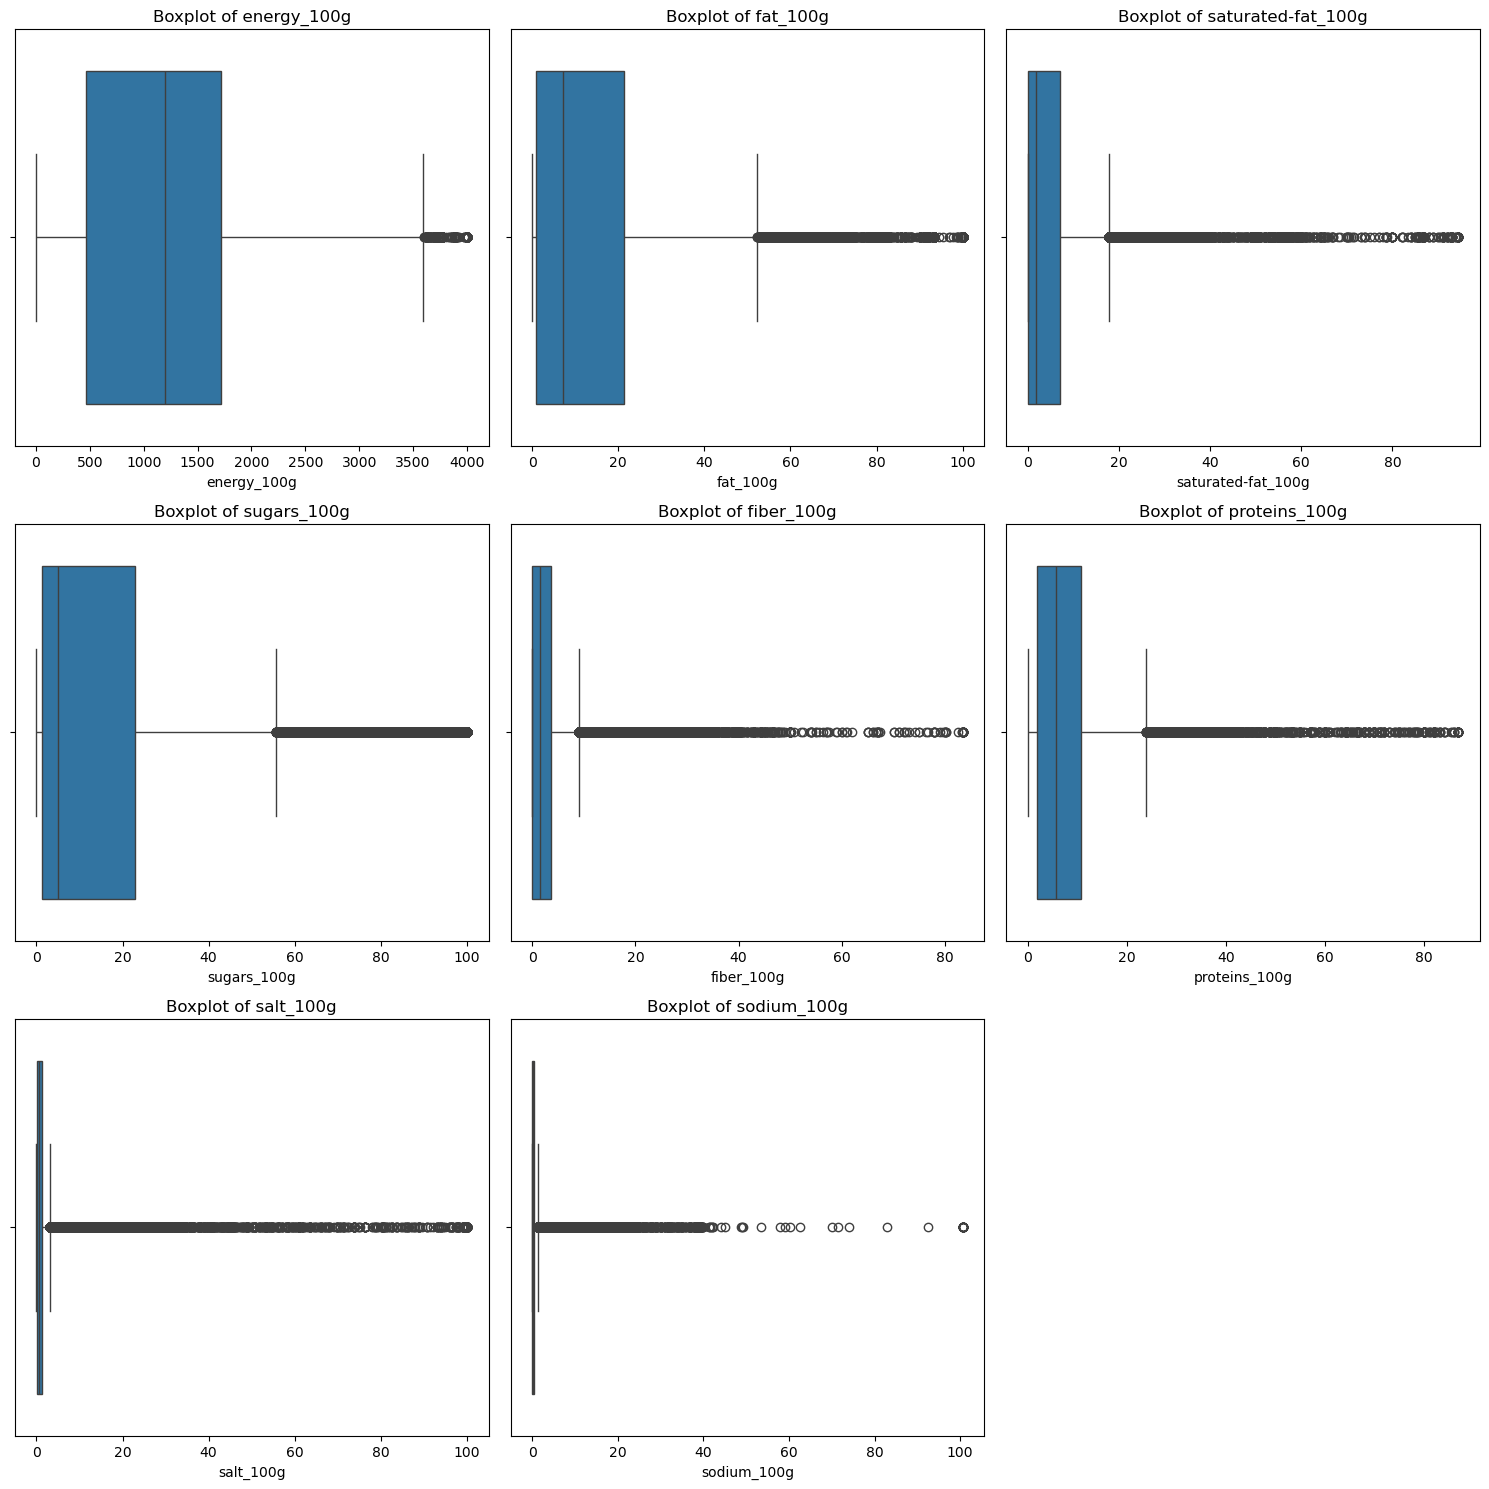

Mean of energy_100g : 1179.1026381465067
Mean of fat_100g : 13.334569562606609
Mean of saturated-fat_100g : 4.975652602263473
Mean of sugars_100g : 14.963757348390649
Mean of fiber_100g : 2.809124990804416
Mean of proteins_100g : 7.772098307026908
Mean of salt_100g : 1.2702882769254091
Mean of sodium_100g : 0.5080762418925446


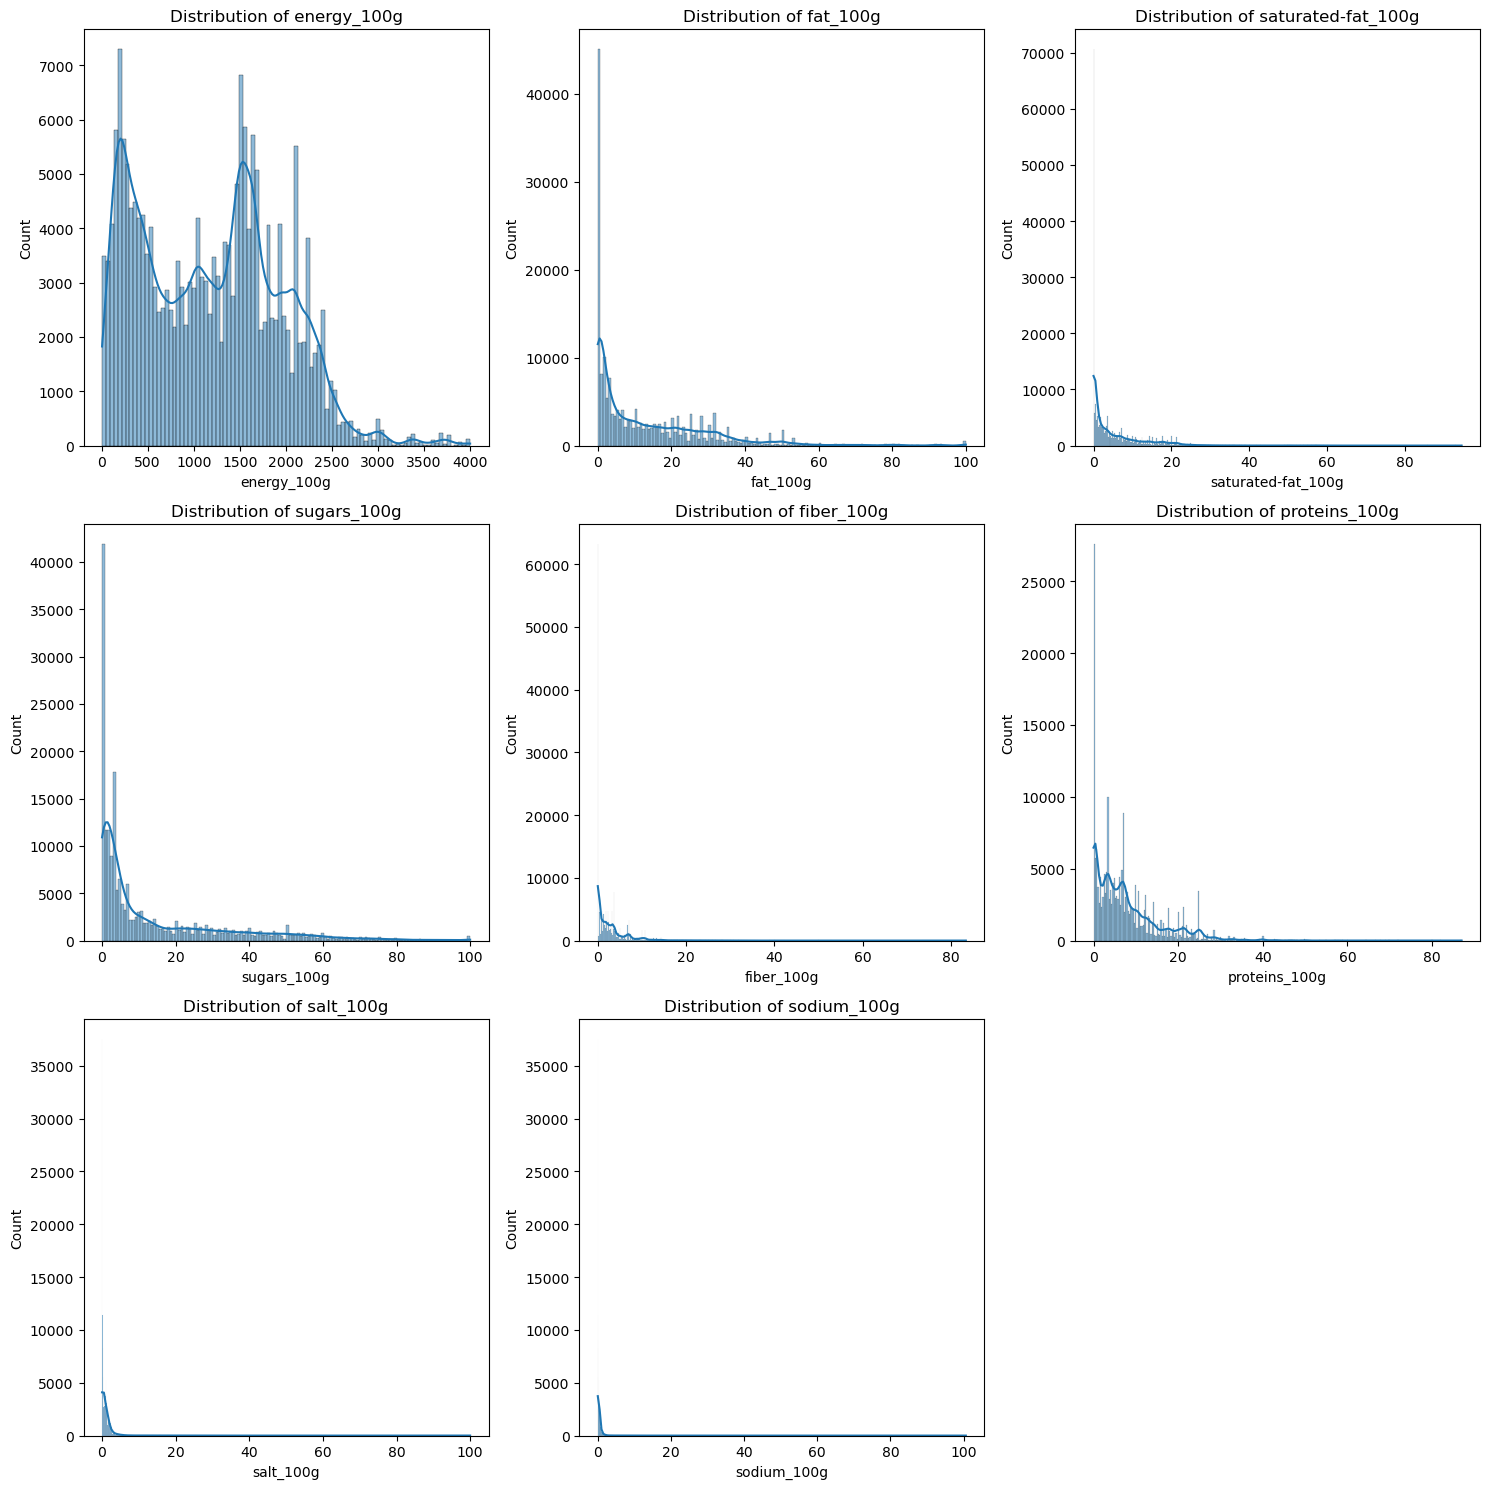

In [32]:
outlierThresholds = {
    'energy_100g': (0, 4000),
    'fat_100g': (0, 100),
    'carbohydrates_100g': (0, 100),
    'proteins_100g': (0, 100),
    'salt_100g': (0, 100)
}

XClean = treat_outliers(XClean, outlierThresholds)
plot_boxplots(XClean, numericColumns)
plot_histograms(XClean, numericColumns)

